# Calculate distances between specific residues in pdb files

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from os.path import exists
from biopandas.pdb import PandasPdb

def sanitize_protein(protein_id):
    "Replace / in protein ID with _ for compatibility with file system"
    return protein_id.replace("/", "_")

def calculate_dist(pdb, XL):
    "Calculate the distance between residues in the PDB based on the crosslink"
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == XL.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == XL.Res2]
    
    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    
    return np.linalg.norm(res_1_coords - res_2_coords)

In [42]:
# Read in XL csv file to pandas DF
XLs = pd.read_csv("Union_XL1_XL2_PurifiedSECa-g_IEXcilia2inject2.3-newpeptidepos.csv", encoding= 'unicode_escape')

# Save all intramolecular crosslinks to a new DF
XLs_intra = XLs.loc[XLs['Protein1'] == XLs['Protein2']]

# Calculate the XL position in the protein primary sequence
XLs_intra['Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
XLs_intra['Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1

# Removes all XL redundancies 
XLs_intra['newRes1'] = XLs_intra[["Res1", "Res2"]].max(axis=1)
XLs_intra['newRes2'] = XLs_intra[["Res1", "Res2"]].min(axis=1)
XLs_intra_nonred = XLs_intra.drop_duplicates(subset=['Protein1', 'Protein2', 'newRes1', 'newRes2'], keep="last")

/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/2994176413.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XLs_intra['Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/2994176413.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XLs_intra['Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/2994176413.py:12: SettingWithCopyWarning: 
A value is

In [43]:
# Extract XL counts
intra_XL_counts = XLs_intra_nonred['Protein1'].value_counts().reset_index().rename(columns = {'index': 'Protein1', 'Protein1': 'XL_count'})

In [131]:
def read_pdb_CA(pdb_filepath):
    ppdb = PandasPdb().read_pdb(pdb_filepath) # reads pdb into pandas df
    pdbatom = ppdb.df['ATOM'] # extracts only the atom data type from pdb
    return pdbatom[(pdbatom['atom_name']=='CA')] # selects the only the CA atoms

def get_XLs_from_pdb(protein_name, threshold, pdb):
    protein_XLs = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein_name]
    protein_XLs['af_distance'] = protein_XLs.apply(lambda x : calculate_dist(pdb, x), axis = 1)
    return protein_XLs[protein_XLs['af_distance'] < threshold]

def get_af_XL_counts(protein_XL_counts, threshold, pdb_suffix):
    protein = protein_XL_counts['Protein1']
    
    pdb_filepath = 'models/' + sanitize_protein(protein) + pdb_suffix
    if (not exists(pdb_filepath)):
        #print(protein + ' PDB file not found. Skipping...')
        return None
    
    pdb_CA = read_pdb_CA(pdb_filepath)
    
    return get_XLs_from_pdb(protein, threshold, pdb_CA).count()['Id']

In [133]:
intra_XL_counts['af_XL_count'] = intra_XL_counts.apply(lambda x : get_af_XL_counts(x, 40, '-unrelaxed_model_1.pdb'), axis = 1)
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement,af_relaxed_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff
4,PRKG1,38,38.0,78.041609,0.947368,38.0,1.000000,2.0
5,EEF2,35,30.0,89.479929,0.714286,30.0,0.857143,5.0
6,MRNC57,34,27.0,68.385990,0.735294,26.0,0.764706,1.0
9,EMAP5/6-1,30,30.0,NaN,1.000000,30.0,1.000000,0.0
10,I7MJ59,30,18.0,67.924191,0.500000,20.0,0.666667,5.0
...,...,...,...,...,...,...,...,...
120,I7LW80,8,8.0,68.536852,1.000000,NaN,NaN,NaN
121,I7LZI8,7,6.0,97.085454,0.857143,NaN,NaN,NaN
123,I7MEJ5,7,7.0,80.420044,1.000000,NaN,NaN,NaN
128,I7MHD4,7,7.0,95.693012,1.000000,NaN,NaN,NaN


## Compare Confidence and XL Agreement

In [46]:
def read_confidence(intra_XL_counts):
    protein = intra_XL_counts['Protein1']
    
    ranking_filepath = 'rankings/' + sanitize_protein(protein) + '-ranking_debug.json'
    if (not exists(ranking_filepath)):
        #print(protein + ' ranking file not found. Skipping...')
        return None
    
    with open(ranking_filepath) as ranking_file:
        ranking_debug = json.load(ranking_file)
        return ranking_debug['plddts']['model_1']

intra_XL_counts['confidence'] = intra_XL_counts.apply(lambda x : read_confidence(x), axis = 1)

In [47]:
intra_XL_counts['XL_agreement'] = intra_XL_counts['af_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement
4,PRKG1,38,36.0,78.041609,0.947368
5,EEF2,35,25.0,89.479929,0.714286
6,MRNC57,34,25.0,68.385990,0.735294
9,EMAP5/6-1,30,30.0,NaN,1.000000
10,I7MJ59,30,15.0,67.924191,0.500000
...,...,...,...,...,...
120,I7LW80,8,8.0,68.536852,1.000000
121,I7LZI8,7,6.0,97.085454,0.857143
123,I7MEJ5,7,7.0,80.420044,1.000000
128,I7MHD4,7,7.0,95.693012,1.000000


<AxesSubplot:xlabel='XL_agreement', ylabel='confidence'>

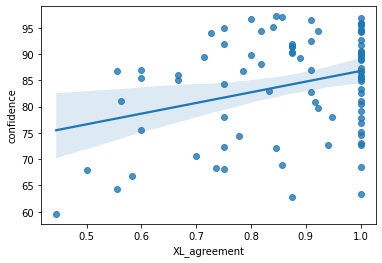

In [48]:
sns.regplot(x = intra_XL_counts['XL_agreement'], y = intra_XL_counts['confidence'])

In [49]:
# plDDT score per residue
# lower score in looped regions between domains (bc alphafold is less confident there)
# identify drops in score to try to break up domains
# Identify drops by seeing if there's a significant deviation from the moving average / deviation?
# Derivative to find an inflection point
# Calculate the plDDT average for the domain
# Figure out crosslinks within the domain, check for XL agreement in each domain
# Plot by domains instead of full protein

# Also: maybe % isn't right, maybe count the # of crosslinks that are (or are not) in agreement

# Can plot position/location vs bfactor/plDDT to see where drops are
# Can maybe steal the code for that from the Colab notebook

# Violin plot combined with swarm plot (seaborn)

## Compare Unrelaxed vs Relaxed XL counts for top 10 most crosslinked proteins

In [134]:
intra_XL_counts['af_relaxed_XL_count'] = intra_XL_counts.apply(lambda x : get_af_XL_counts(x, 40, '-relaxed_model_1.pdb'), axis = 1)
intra_XL_counts['relaxed_XL_agreement'] = intra_XL_counts['af_relaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_vs_unrelaxed_diff'] = intra_XL_counts['af_relaxed_XL_count'] - intra_XL_counts['af_XL_count']
intra_XL_counts[intra_XL_counts['af_relaxed_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement,af_relaxed_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff
4,PRKG1,38,38.0,78.041609,0.947368,38.0,1.000000,0.0
5,EEF2,35,30.0,89.479929,0.714286,30.0,0.857143,0.0
6,MRNC57,34,27.0,68.385990,0.735294,26.0,0.764706,-1.0
9,EMAP5/6-1,30,30.0,NaN,1.000000,30.0,1.000000,0.0
10,I7MJ59,30,18.0,67.924191,0.500000,20.0,0.666667,2.0
11,BBC118,25,18.0,85.481704,0.600000,18.0,0.720000,0.0
12,FTT18,25,21.0,95.138586,0.840000,21.0,0.840000,0.0
13,EARS,24,24.0,91.715565,1.000000,24.0,1.000000,0.0
14,EMAP5/6-2,22,22.0,NaN,1.000000,22.0,1.000000,0.0
16,Q23A15,20,16.0,75.527561,0.600000,15.0,0.750000,-1.0


## Examine plDDT pattern in protein PRKG1 and I7MJ59 to see how to extract domains

In [122]:
pdb_CA = read_pdb_CA('models/PRKG1-relaxed_model_1.pdb')
if pdb_CA is None:
    print('PRKG1 relaxed model not found')

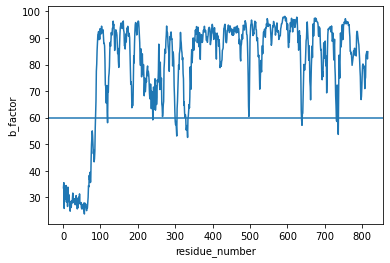

In [124]:
plddt_plot = sns.lineplot(x = pdb_CA.residue_number, y = pdb_CA.b_factor)
plddt_plot.axhline(60)
plt.show()

/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/915722203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_threshold['prev_residue_number'] = subset_threshold['residue_number'].shift(1)
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/915722203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_threshold['new_domain'] = subset_threshold['residue_number'] - subset_threshold['prev_residue_number'] > 1
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel

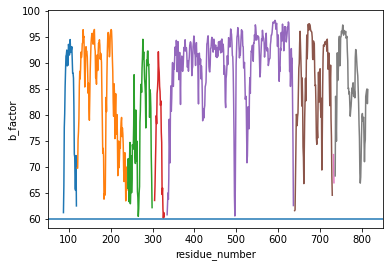

In [125]:
subset_threshold = pdb_CA[pdb_CA['b_factor'] > 60]
subset_threshold['prev_residue_number'] = subset_threshold['residue_number'].shift(1)
subset_threshold['new_domain'] = subset_threshold['residue_number'] - subset_threshold['prev_residue_number'] > 1

domain_number = 1

def determine_domain(residue):
    global domain_number
    if residue['new_domain']:
        domain_number += 1
    return domain_number

subset_threshold['domain_number'] = subset_threshold.apply(determine_domain, axis = 1)

plddt_plot = sns.lineplot(x = subset_threshold.residue_number, y = subset_threshold.b_factor, hue = subset_threshold.domain_number, palette = 'tab10', legend = False)
plddt_plot.axhline(60)
plt.show()

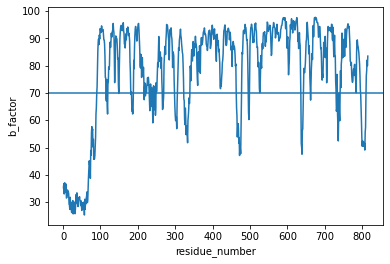

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


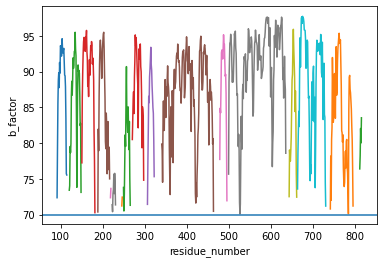

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
10661,10662,121.68,PRKG1,435,TDGVISSISYKTFQK,11,PRKG1,365,ITNNCKIANLK,6,445,370,445,370,13.343171
13396,13397,92.69,PRKG1,405,EIATKGQMYGDEFLITSK,5,PRKG1,346,WSFAKSDLLK,5,409,350,409,350,13.325997
14569,14570,76.55,PRKG1,446,TFQKCIGGDIEK,4,PRKG1,365,ITNNCKIANLK,6,449,370,449,370,14.927470
18184,18185,41.37,PRKG1,346,WSFAKSDLLK,5,PRKG1,356,QLTKIQVEK,4,350,359,359,350,14.309536


In [120]:
# Functions for only calculating intra-domain XL af distances

domain_number = 1

def determine_domain(residue):
    global domain_number
    if residue['new_domain']:
        domain_number += 1
    return domain_number

def calculate_dist_in_domain(pdb, XL):
    "Calculate the distance between residues in the PDB based on the crosslink"
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == XL.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == XL.Res2]
    
    if (res_1.empty or res_2.empty):
        return None
    
    if (res_1.iloc[0]['domain_number'] != res_2.iloc[0]['domain_number']):
        return None
    
    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    
    return np.linalg.norm(res_1_coords - res_2_coords)

def get_XLs_from_pdb_domains(protein_name, pdb):
    protein_XLs = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein_name]
    protein_XLs.loc[:, 'af_distance'] = protein_XLs.apply(lambda x : calculate_dist_in_domain(pdb, x), axis = 1)
    return protein_XLs

def intra_domain_XLs(protein_name):
    pdb_CA = read_pdb_CA('models/{}-unrelaxed_model_1.pdb'.format(sanitize_protein(protein_name)))
    if pdb_CA is None:
        return pd.DataFrame()
    
    plddt_plot = sns.lineplot(x = pdb_CA.residue_number, y = pdb_CA.b_factor)
    plddt_plot.axhline(70)
    plt.show()
    
    subset_threshold = pdb_CA[pdb_CA['b_factor'] > 70]
    subset_threshold.loc[:, 'prev_residue_number'] = subset_threshold['residue_number'].shift(1)
    subset_threshold.loc[:, 'new_domain'] = subset_threshold['residue_number'] - subset_threshold['prev_residue_number'] > 1
    
    subset_threshold.loc[:, 'domain_number'] = subset_threshold.apply(determine_domain, axis = 1)

    plddt_plot = sns.lineplot(x = subset_threshold.residue_number, y = subset_threshold.b_factor, hue = subset_threshold.domain_number, palette = 'tab10', legend = False)
    plddt_plot.axhline(70)
    plt.show()
    
    intra_domain_XLs = get_XLs_from_pdb_domains(protein_name, subset_threshold)
    return intra_domain_XLs[intra_domain_XLs['af_distance'].notnull()]

intra_domain_XLs('PRKG1')

In [126]:
test = get_XLs_from_pdb_domains('PRKG1', subset_threshold)
print(test[test['af_distance'] < 30].count()['Id'], 'AF distance < 30')
print(test[test['af_distance'].notnull()].count()['Id'], 'have experimental XLs')
test[test['af_distance'].notnull()]

11 AF distance < 30
11 have experimental XLs


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
8914,8915,137.84,PRKG1,469,KMANLEDK,1,PRKG1,477,KDYSHIK,1,469,477,477,469,16.891234
10661,10662,121.68,PRKG1,435,TDGVISSISYKTFQK,11,PRKG1,365,ITNNCKIANLK,6,445,370,445,370,13.541136
12117,12118,107.19,PRKG1,506,NKDSGALYALK,2,PRKG1,477,KDYSHIK,1,507,477,507,477,18.419902
12714,12715,100.69,PRKG1,461,ANEDSHEKK,8,PRKG1,351,SDLLKQLTK,5,468,355,468,355,12.553243
13396,13397,92.69,PRKG1,405,EIATKGQMYGDEFLITSK,5,PRKG1,346,WSFAKSDLLK,5,409,350,409,350,13.025614
14569,14570,76.55,PRKG1,446,TFQKCIGGDIEK,4,PRKG1,365,ITNNCKIANLK,6,449,370,449,370,15.052696
15966,15967,51.98,PRKG1,478,DYSHIKLDHLIFIK,6,PRKG1,506,NKDSGALYALK,2,483,507,507,483,9.498373
16340,16341,46.57,PRKG1,356,QLTKIQVEK,4,PRKG1,461,ANEDSHEKK,8,359,468,468,359,10.381929
16765,16766,41.57,PRKG1,806,ARDPNWDKDF,8,PRKG1,800,EYNKER,4,813,803,813,803,10.941873
16792,16793,41.24,PRKG1,521,AQIIEQNLEKHLLQEK,10,PRKG1,634,ILKQGK,3,530,636,636,530,16.739977


In [106]:
# Try same with another protein

pdb_CA = read_pdb_CA('models/I7MJ59-relaxed_model_1.pdb')
if pdb_CA is None:
    print('I7MJ59 relaxed model not found')

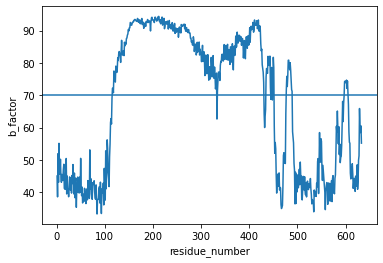

In [107]:
plddt_plot = sns.lineplot(x = pdb_CA.residue_number, y = pdb_CA.b_factor)
plddt_plot.axhline(70)
plt.show()

/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/2810867469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_threshold['prev_residue_number'] = subset_threshold['residue_number'].shift(1)
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/2810867469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_threshold['new_domain'] = subset_threshold['residue_number'] - subset_threshold['prev_residue_number'] > 1
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykern

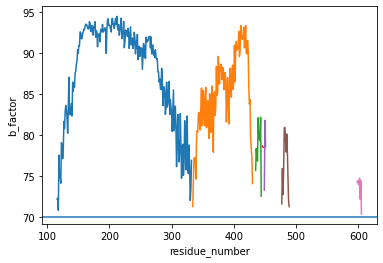

In [108]:
subset_threshold = pdb_CA[pdb_CA['b_factor'] > 70]
subset_threshold['prev_residue_number'] = subset_threshold['residue_number'].shift(1)
subset_threshold['new_domain'] = subset_threshold['residue_number'] - subset_threshold['prev_residue_number'] > 1

domain_number = 1

subset_threshold['domain_number'] = subset_threshold.apply(determine_domain, axis = 1)

plddt_plot = sns.lineplot(x = subset_threshold.residue_number, y = subset_threshold.b_factor, hue = subset_threshold.domain_number, palette = 'tab10', legend = False)
plddt_plot.axhline(70)
plt.show()

In [109]:
test = get_XLs_from_pdb_domains('I7MJ59', subset_threshold)
print(test[test['af_distance'] < 30].count()['Id'], 'AF distance < 30')
print(test[test['af_distance'].notnull()].count()['Id'], 'have experimental XLs')
test[test['af_distance'].notnull()]

14 AF distance < 30
17 have experimental XLs


/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_23133/4284026447.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_XLs['af_distance'] = protein_XLs.apply(lambda x : calculate_dist_in_domain(pdb, x), axis = 1)


,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
3372,3373,196.06,I7MJ59,389,LQDLQNLQEYQTFKK,14,I7MJ59,404,QEDADNKKK,7,402,410,410,402,12.213357
4984,4985,175.93,I7MJ59,413,YKDFLDQQYK,2,I7MJ59,404,QEDADNKKK,8,414,411,414,411,5.080295
5735,5736,167.89,I7MJ59,149,MMQQLQQKQQELNYK,8,I7MJ59,128,KNEIEINR,1,156,128,156,128,41.767487
6554,6555,159.14,I7MJ59,389,LQDLQNLQEYQTFKK,14,I7MJ59,413,YKDFLDQQYK,2,402,414,414,402,18.250813
7082,7083,153.95,I7MJ59,412,KYKDFLDQQYK,1,I7MJ59,403,KQEDADNKK,1,412,403,412,403,14.343892
7915,7916,146.71,I7MJ59,372,YQNELEKNLK,7,I7MJ59,363,NQYLMGEKK,8,378,370,378,370,12.245477
11802,11803,110.76,I7MJ59,371,KYQNELEK,1,I7MJ59,379,NLKEQQVK,3,371,381,381,371,15.342743
11851,11852,110.31,I7MJ59,218,NDWENKLLEYNQQR,6,I7MJ59,209,KDQEYK,1,223,209,223,209,20.834551
12694,12695,100.93,I7MJ59,342,LQSEIDKIQR,7,I7MJ59,379,NLKEQQVK,3,348,381,381,348,49.647679
13052,13053,97.13,I7MJ59,307,LHENHFNNVYMPLVKK,15,I7MJ59,325,ELEDLISKGVTEAER,8,321,332,332,321,16.683320


In [110]:
# What is in the pkl file?
results = pd.read_pickle('results/PRKG1-result_model_1.pkl')
results

{'distogram': {'bin_edges': array([ 2.3125  ,  2.625   ,  2.9375  ,  3.25    ,  3.5625  ,  3.875   ,
          4.1875  ,  4.5     ,  4.8125  ,  5.125   ,  5.4375  ,  5.75    ,
          6.0625  ,  6.375   ,  6.6875  ,  7.      ,  7.3125  ,  7.625   ,
          7.9375  ,  8.25    ,  8.5625  ,  8.875   ,  9.1875  ,  9.5     ,
          9.812499, 10.125   , 10.4375  , 10.75    , 11.0625  , 11.375   ,
         11.6875  , 12.      , 12.3125  , 12.625   , 12.9375  , 13.25    ,
         13.5625  , 13.875   , 14.1875  , 14.499999, 14.8125  , 15.125   ,
         15.4375  , 15.75    , 16.0625  , 16.375   , 16.6875  , 16.999998,
         17.312498, 17.625   , 17.9375  , 18.25    , 18.5625  , 18.875   ,
         19.1875  , 19.5     , 19.8125  , 20.125   , 20.437498, 20.75    ,
         21.0625  , 21.375   , 21.6875  ], dtype=float32),
  'logits': array([[[ 1.43151794e+02, -4.32302713e-01, -1.71075516e+01, ...,
           -5.44000282e+01, -5.39171906e+01, -7.86112976e+01],
          [ 6.31659031e+0

In [ ]:
## PRKG1 run w/ ptm
## EEF2 run w/ ptm
## identify domains using PAE